# Data Preparation

## Imports

In [2]:
import pandas as pd
import numpy as np
import ast
import pytz
import re
import matplotlib.pyplot as plt
import xgboost as xgb 
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")


## Read files and concatenate ID orderbooks

In [4]:
# 01.01.2024 00:00 - 31.12.2024 23:00 (CET)
da_prices_df = pd.read_parquet('Data/da_prices_2024.parquet')

In [7]:
# 01.01.2024 01:00 - 01.04.2024 21:00 (UCT)
orderbook_q1 = pd.read_parquet('Data/orderbook_q1.parquet')

# 01.04.2024 00:00 - 01.07.2024 21:00 (UCT)
orderbook_q2 = pd.read_parquet('Data/orderbook_q2.parquet')

# 01.07.2024 00:00 - 01.10.2024 21:00 (UCT)
orderbook_q3 = pd.read_parquet('Data/orderbook_q3.parquet')

# 01.10.2024 00:00 - 01.01.2025 22:00 (UCT)
orderbook_q4 = pd.read_parquet('Data/orderbook_q4.parquet')

In [8]:
orderbook_q2

,contractId,contractName,dlvryStart,dlvryEnd,dlvryAreaId,marketId,area,recorded,time,orderId_bid,orderId_ask,orderPrice_bid,orderPrice_ask,orderQty_bid,orderQty_ask
0,NX_444231,PH-20240401-03,2024-04-01 00:00:00.000 +0000,2024-04-01 01:00:00.000 +0000,10,N_2,NO3,2024-03-31 22:39:07.227 +0000,2024-03-31 22:00:00.000 +0000,"{'X6295172897','X6299316163','X6299434042','X6...","{'X6298407875','X6293723967','X6293723971','X6...","{4300,4148,3611,3601,3600,3521,3521,3521,3521,...","{5269,5300,5300,5300,5400,5500,5500,5500,5600,...","{4000,10000,100,3000,11000,100,200,700,3000,8000}","{200,5000,7000,8000,2000,8000,6000,7000,10000,..."
1,NX_444238,PH-20240401-04,2024-04-01 01:00:00.000 +0000,2024-04-01 02:00:00.000 +0000,10,N_2,NO3,2024-03-31 22:39:23.090 +0000,2024-03-31 22:00:00.000 +0000,"{'X6293919201','X6299264895','X6299315190','X6...","{'X6296305108','X6298927096','X6293723977','X6...","{4200,4200,4094,3739,3739,3722,3711,3711,3656,...","{4963,5240,5300,5300,5300,5300,5400,5400,5400,...","{3000,2000,10000,3500,5000,1800,200,100,100,200}","{5000,400,5000,7000,8000,3000,8000,6000,7000,1..."
2,NX_444245,PH-20240401-05,2024-04-01 02:00:00.000 +0000,2024-04-01 03:00:00.000 +0000,10,N_2,NO3,2024-03-31 22:39:33.786 +0000,2024-03-31 22:00:00.000 +0000,"{'X6299428911','X6299431105','X6299426834','X6...","{'X6299291873','X6299291874','X6293919204','X6...","{4019,4011,4010,4002,4002,4000,3997,3860,3210,...","{4890,4890,4900,5200,5291,5300,5300,5300,5500,...","{5000,5000,1000,3000,100,4200,4300,100,5000,5000}","{5000,5000,6000,5900,300,5000,7000,8000,8000,6..."
3,NX_444252,PH-20240401-06,2024-04-01 03:00:00.000 +0000,2024-04-01 04:00:00.000 +0000,10,N_2,NO3,2024-03-31 22:39:42.530 +0000,2024-03-31 22:00:00.000 +0000,"{'X6299412843','X6299412951','X6299183946','X6...","{'X6299242518','X6299242522','X6299433265','X6...","{3352,3352,3340,3257,2950,2950,2949,2171,1801,...","{3665,3665,4489,4489,4489,4489,4490,4521,4540,...","{2000,4000,3000,100,5000,5000,5000,4000,5000,1...","{5000,3300,5000,4000,5000,4300,500,400,100,200}"
4,NX_444259,PH-20240401-07,2024-04-01 04:00:00.000 +0000,2024-04-01 05:00:00.000 +0000,10,N_2,NO3,2024-03-31 22:39:49.954 +0000,2024-03-31 22:00:00.000 +0000,"{'X6299328810','X6294215040','X6299272048','X6...","{'X6299433898','X6299313658','X6299424351','X6...","{3688,3488,3192,3003,2972,2701,2001,2000,2000,...","{4990,5000,5032,5032,5032,5032,5053,5073,5073,...","{1000,3300,1000,4000,6000,4000,5000,10000,4000...","{4000,1300,100,200,700,3000,8000,5000,7000,5000}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686315,NX_461925,PH-20240701-20,2024-07-01 17:00:00.000 +0000,2024-07-01 18:00:00.000 +0000,10,N_2,NO3,2024-07-01 09:41:27.133 +0000,2024-06-30 21:59:00.000 +0000,"{'X7440512493','X7440512664','X7440512680','X7...","{'X7440411191','X7440646793','X7437010366','X7...","{3395,3392,3392,3390,3290,3095,3090,2990,2810,...","{3895,3897,5000,5005,5350,5910,9819,9819,9822,...","{5000,5000,2000,5000,10000,5000,10000,10000,25...","{5000,5000,5000,5000,6000,5000,5000,5000,4000,..."
2686316,NX_461932,PH-20240701-21,2024-07-01 18:00:00.000 +0000,2024-07-01 19:00:00.000 +0000,10,N_2,NO3,2024-07-01 08:41:02.203 +0000,2024-06-30 21:59:00.000 +0000,"{'X7440512494','X7440512667','X7440512678','X7...","{'X7440512381','X7440653694','X7436927087','X7...","{3352,3352,3352,3350,3250,3115,3035,3035,3034,...","{3797,3797,5430,5910,13340,13340,13340,13340,1...","{5000,5000,2000,5000,10000,5000,2000,2000,2500...","{5000,2500,5000,5000,5000,5000,4500,10000,5000..."
2686317,NX_461940,PH-20240701-22,2024-07-01 19:00:00.000 +0000,2024-07-01 20:00:00.000 +0000,10,N_2,NO3,2024-07-01 08:41:11.710 +0000,2024-06-30 21:59:00.000 +0000,"{'X7440512495','X7440512682','X7440512357','X7...","{'X7440655056','X7440655061','X7440654916','X7...","{3275,3275,3270,3170,2885,2870,2795,2795,2795,...","{3697,3697,3700,5600,5910,11639,12417,12500,12...","{2500,2000,5000,10000,5000,10000,2500,2000,200...","{2500,5000,10000,4000,5000,1400,5000,2000,400,..

In [9]:
# Concatenate the ID orderbooks
orderbook_df = pd.concat([orderbook_q1, orderbook_q2, orderbook_q3, orderbook_q4])
orderbook_df.to_parquet('Data/orderbook.parquet')

In [10]:
da_prices_df.dtypes

Delivery Start (CET)     object
Delivery End (CET)       object
NO3 Price (EUR)         float64
dtype: object

## Convert columns to datetime

In [11]:
# The coulumns dlvryStart, dlvryEnd and time are in string format. We need to convert them to datetime format.|
orderbook_df['dlvryStart'] = pd.to_datetime(orderbook_df['dlvryStart'])
orderbook_df['dlvryEnd'] = pd.to_datetime(orderbook_df['dlvryEnd'])
orderbook_df['time'] = pd.to_datetime(orderbook_df['time'])

In [12]:
# Convert string columns to datetime objects (without timezone info initially)
da_prices_df['Delivery Start (CET)'] = pd.to_datetime(da_prices_df['Delivery Start (CET)'], format="%d.%m.%Y %H:%M:%S")
da_prices_df['Delivery End (CET)'] = pd.to_datetime(da_prices_df['Delivery End (CET)'], format="%d.%m.%Y %H:%M:%S")

# Localize to CET timezone
cet = pytz.timezone('CET')
da_prices_df['Delivery Start (CET)'] = da_prices_df['Delivery Start (CET)'].dt.tz_localize(cet, ambiguous='infer')
da_prices_df['Delivery End (CET)'] = da_prices_df['Delivery End (CET)'].dt.tz_localize(cet, ambiguous='infer')

# Convert from CET to UCT
da_prices_df['Delivery Start (UTC)'] = da_prices_df['Delivery Start (CET)'].dt.tz_convert('UTC')
da_prices_df['Delivery End (UTC)'] = da_prices_df['Delivery End (CET)'].dt.tz_convert('UTC')

In [13]:
da_prices_df.dtypes

Delivery Start (CET)    datetime64[ns, CET]
Delivery End (CET)      datetime64[ns, CET]
NO3 Price (EUR)                     float64
Delivery Start (UTC)    datetime64[ns, UTC]
Delivery End (UTC)      datetime64[ns, UTC]
dtype: object

In [14]:
# Remove the CET columns
da_prices_df = da_prices_df.drop(columns=['Delivery Start (CET)', 'Delivery End (CET)'])

In [15]:
da_prices_df

,NO3 Price (EUR),Delivery Start (UTC),Delivery End (UTC)
0,29.56,2023-12-31 23:00:00+00:00,2024-01-01 00:00:00+00:00
1,28.46,2024-01-01 00:00:00+00:00,2024-01-01 01:00:00+00:00
2,26.66,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00
3,24.48,2024-01-01 02:00:00+00:00,2024-01-01 03:00:00+00:00
4,24.01,2024-01-01 03:00:00+00:00,2024-01-01 04:00:00+00:00
...,...,...,...
8779,10.17,2024-12-31 18:00:00+00:00,2024-12-31 19:00:00+00:00
8780,10.64,2024-12-31 19:00:00+00:00,2024-12-31 20:00:00+00:00
8781,7.13,2024-12-31 20:00:00+00:00,2024-12-31 21:00:00+00:00
8782,7.16,2024-12-31 21:00:00+00:00,2024-12-31 22:00:00+00:00


## Merge ID orderbook with DA prices

In [16]:
# Merge the ID orderbook with the DA prices.
df = pd.merge(orderbook_df, da_prices_df, left_on='dlvryStart', right_on='Delivery Start (UTC)', how='left')

In [17]:
df

,contractId,contractName,dlvryStart,dlvryEnd,dlvryAreaId,marketId,area,recorded,time,orderId_bid,orderId_ask,orderPrice_bid,orderPrice_ask,orderQty_bid,orderQty_ask,NO3 Price (EUR),Delivery Start (UTC),Delivery End (UTC)
0,NX_426231,PH-20240101-03,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,10,N_2,NO3,2024-03-06 10:24:54.175 +0000,2023-12-31 23:00:00+00:00,"{'X5385339387','X5385339295','X5385350510','X5...","{'X5385371204','X5385374175','X5385353666','X5...","{2247,2100,2000,2000,1751,1443,1212,1205,1205,...","{2350,2378,2409,2497,2514,2559,2590,2600,2657,...","{500,5000,800,1600,1000,700,5000,5200,800,2200}","{10000,2000,5000,1000,200,500,300,10000,4000,500}",26.66,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00
1,NX_426238,PH-20240101-04,2024-01-01 02:00:00+00:00,2024-01-01 03:00:00+00:00,10,N_2,NO3,2024-03-06 10:24:56.947 +0000,2023-12-31 23:00:00+00:00,"{'X5385372330','X5385372495','X5385371311','X5...","{'X5385372323','X5385372333','X5385373948','X5...","{2061,2061,2051,2000,2000,2000,1920,1467,1000,...","{2251,2251,2262,2299,2300,2433,2447,2448,2551,...","{1900,3000,100,5000,800,1500,400,500,1000,1000}","{200,500,200,3000,10000,500,3600,15000,4000,4000}",24.48,2024-01-01 02:00:00+00:00,2024-01-01 03:00:00+00:00
2,NX_426245,PH-20240101-05,2024-01-01 03:00:00+00:00,2024-01-01 04:00:00+00:00,10,N_2,NO3,2024-03-06 10:25:00.755 +0000,2023-12-31 23:00:00+00:00,"{'X5385359141','X5385367235','X5385367212','X5...","{'X5385364822','X5385364828','X5385364821','X5...","{2000,1950,1927,1917,1916,1320,1319,1319,1319,...","{2127,2127,2129,2150,2200,2400,2400,2401,2401,...","{100,100,1200,9000,2000,4500,1600,500,1000,1000}","{200,5000,400,10000,2000,4000,5000,500,15000,400}",24.01,2024-01-01 03:00:00+00:00,2024-01-01 04:00:00+00:00
3,NX_426252,PH-20240101-06,2024-01-01 04:00:00+00:00,2024-01-01 05:00:00+00:00,10,N_2,NO3,2024-03-06 10:25:06.307 +0000,2023-12-31 23:00:00+00:00,"{'X5385371584','X5385371589','X5385371590','X5...","{'X5385363190','X5385363118','X5383614807','X5...","{1574,1574,1574,1574,1574,1574,1424,1423,1000,...","{1798,1800,1875,2050,2123,2423,2504,2550,2670,...","{1500,5000,1000,2000,1000,5000,2000,5000,1000,...","{10000,10000,10000,5000,15000,1000,1900,10000,...",21.23,2024-01-01 04:00:00+00:00,2024-01-01 05:00:00+00:00
4,NX_426260,PH-20240101-07,2024-01-01 05:00:00+00:00,2024-01-01 06:00:00+00:00,10,N_2,NO3,2024-03-06 10:25:10.161 +0000,2023-12-31 23:00:00+00:00,"{'X5384463871','X5385167819','X5385169379','X5...","{'X5385370820','X5385371596','X5385371593','X5...","{1748,1748,1748,1748,1746,1520,1500,1500,1362,...","{2039,2089,2090,2262,2462,2562,2670,2700,2710,...","{4900,1000,1000,500,5000,1000,2000,1300,5000,5...","{500,1000,10000,15000,10000,1000,5000,5000,100...",22.62,2024-01-01 05:00:00+00:00,2024-01-01 06:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10768015,NX_496910,PH-20250101-20,2025-01-01 18:00:00+00:00,2025-01-01 19:00:00+00:00,10,N_2,NO3,2024-12-31 23:43:44.288 +0000,2024-12-31 22:59:00+00:00,"{'X10233448499','X10234051602','X10234052934',...","{'X10232980063','X10228851570','X10232667440',...","{980,828,828,809,743,721,721,658,575,545}","{2775,2780,2780,2810,2810,2870,2900,3500}","{3900,4000,5000,5000,5000,5000,4000,800,2000,200}","{200,8000,5000,5000,5000,10000,2700,10000}",NaN,NaT,NaT
10768016,NX_496918,PH-20250101-21,2025-01-01 19:00:00+00:00,2025-01-01 20:00:00+00:00,10,N_2,NO3,2024-12-31 23:43:48.436 +0000,2024-12-31 22:59:00+00:00,"{'X10233744528','X10233744531','X10233744825',...","{'X10228851573','X10229998186','X10229998185',...","{513,513,509,500,498,498,497,394,377,376}","{2780,2780,2810,2810,2820,2870,2900,2900,2950,...","{5000,5000,5000,3900,5000,5000,300,2500,5000,6...","{6400,5000,5000,5000,10000,10000,1900,5000,700...",NaN,NaT,NaT
10768017,NX_496925,PH-20250101-22,2025-01-01 20:00:00+00:00,2025-01-01 21:00:00+00:00,10,N_2,NO3,2024-12-31 23:43:52.589 +0000,2024-12-31 22:59:00+00:00,"{'X10234238392','X10234238451','X10234238459',...",

## Remove rows where DA price is NaN
DA prices go a little bit further than the orderbook. Remove these

In [18]:
df = df.dropna(subset=['NO3 Price (EUR)'])

## Write merged orderbook to parquet

In [19]:
df.to_parquet('Data/merged_orderbook.parquet')

## Start here

In [3]:
df = pd.read_parquet('Data/merged_orderbook.parquet')

In [25]:
df

,contractId,contractName,dlvryStart,dlvryEnd,dlvryAreaId,marketId,area,recorded,time,orderId_bid,orderId_ask,orderPrice_bid,orderPrice_ask,orderQty_bid,orderQty_ask,NO3 Price (EUR),Delivery Start (UTC),Delivery End (UTC)
index,,,,,,,,,,,,,,,,,,
0,NX_426231,PH-20240101-03,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00,10,N_2,NO3,2024-03-06 10:24:54.175 +0000,2023-12-31 23:00:00+00:00,"{'X5385339387','X5385339295','X5385350510','X5...","{'X5385371204','X5385374175','X5385353666','X5...","{2247,2100,2000,2000,1751,1443,1212,1205,1205,...","{2350,2378,2409,2497,2514,2559,2590,2600,2657,...","{500,5000,800,1600,1000,700,5000,5200,800,2200}","{10000,2000,5000,1000,200,500,300,10000,4000,500}",26.66,2024-01-01 01:00:00+00:00,2024-01-01 02:00:00+00:00
1,NX_426238,PH-20240101-04,2024-01-01 02:00:00+00:00,2024-01-01 03:00:00+00:00,10,N_2,NO3,2024-03-06 10:24:56.947 +0000,2023-12-31 23:00:00+00:00,"{'X5385372330','X5385372495','X5385371311','X5...","{'X5385372323','X5385372333','X5385373948','X5...","{2061,2061,2051,2000,2000,2000,1920,1467,1000,...","{2251,2251,2262,2299,2300,2433,2447,2448,2551,...","{1900,3000,100,5000,800,1500,400,500,1000,1000}","{200,500,200,3000,10000,500,3600,15000,4000,4000}",24.48,2024-01-01 02:00:00+00:00,2024-01-01 03:00:00+00:00
2,NX_426245,PH-20240101-05,2024-01-01 03:00:00+00:00,2024-01-01 04:00:00+00:00,10,N_2,NO3,2024-03-06 10:25:00.755 +0000,2023-12-31 23:00:00+00:00,"{'X5385359141','X5385367235','X5385367212','X5...","{'X5385364822','X5385364828','X5385364821','X5...","{2000,1950,1927,1917,1916,1320,1319,1319,1319,...","{2127,2127,2129,2150,2200,2400,2400,2401,2401,...","{100,100,1200,9000,2000,4500,1600,500,1000,1000}","{200,5000,400,10000,2000,4000,5000,500,15000,400}",24.01,2024-01-01 03:00:00+00:00,2024-01-01 04:00:00+00:00
3,NX_426252,PH-20240101-06,2024-01-01 04:00:00+00:00,2024-01-01 05:00:00+00:00,10,N_2,NO3,2024-03-06 10:25:06.307 +0000,2023-12-31 23:00:00+00:00,"{'X5385371584','X5385371589','X5385371590','X5...","{'X5385363190','X5385363118','X5383614807','X5...","{1574,1574,1574,1574,1574,1574,1424,1423,1000,...","{1798,1800,1875,2050,2123,2423,2504,2550,2670,...","{1500,5000,1000,2000,1000,5000,2000,5000,1000,...","{10000,10000,10000,5000,15000,1000,1900,10000,...",21.23,2024-01-01 04:00:00+00:00,2024-01-01 05:00:00+00:00
4,NX_426260,PH-20240101-07,2024-01-01 05:00:00+00:00,2024-01-01 06:00:00+00:00,10,N_2,NO3,2024-03-06 10:25:10.161 +0000,2023-12-31 23:00:00+00:00,"{'X5384463871','X5385167819','X5385169379','X5...","{'X5385370820','X5385371596','X5385371593','X5...","{1748,1748,1748,1748,1746,1520,1500,1500,1362,...","{2039,2089,2090,2262,2462,2562,2670,2700,2710,...","{4900,1000,1000,500,5000,1000,2000,1300,5000,5...","{500,1000,10000,15000,10000,1000,5000,5000,100...",22.62,2024-01-01 05:00:00+00:00,2024-01-01 06:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765075,NX_496748,PH-20241231-24,2024-12-31 22:00:00+00:00,2024-12-31 23:00:00+00:00,10,N_2,NO3,2024-12-31 21:39:10.554 +0000,2024-12-31 20:55:00+00:00,"{'X10224735588','X10231756122','X10226066681',...","{'X10226066683','X10232275812','X10223438983',...","{1262,1100,885,885,650,640,586,371,370,340}","{1685,1889,1973,2260,2310,2535,2535,2535,2700,...","{4300,6900,5200,1700,1000,200,10000,100,5300,200}","{1500,200,300,2000,200,5000,5000,5000,5000,5000}",12.85,2024-12-31 22:00:00+00:00,2024-12-31 23:00:00+00:00
10765100,NX_496748,PH-20241231-24,2024-12-31 22:00:00+00:00,2024-12-31 23:00:00+00:00,10,N_2,NO3,2024-12-31 21:39:10.554 +0000,2024-12-31 20:56:00+00:00,"{'X10224735588','X10231756122','X10226066681',...","{'X10226066683','X10232275812','X10223438983',...","{1262,1100,885,885,690,680,586,371,370,344}","{1685,1889,1973,2250,2270,2531,2531,2531,2700,...","{4300,6900,5200,1700,1000,200,10000,100,5300,1...","{1500,200,300,2000,200,5000,5000,5000,5000,5000}",12.85,2024-12-31 22:00:00+00:00,2024-12-31 23:00:00+00:00
10765125,NX_496748,PH-20241231-24,2024-12-31 22:00:00+00:00,2024-12-31 2

In [21]:
df.dtypes

contractId                           object
contractName                         object
dlvryStart              datetime64[ns, UTC]
dlvryEnd                datetime64[ns, UTC]
dlvryAreaId                           int64
marketId                             object
area                                 object
recorded                             object
time                    datetime64[ns, UTC]
orderId_bid                          object
orderId_ask                          object
orderPrice_bid                       object
orderPrice_ask                       object
orderQty_bid                         object
orderQty_ask                         object
NO3 Price (EUR)                     float64
Delivery Start (UTC)    datetime64[ns, UTC]
Delivery End (UTC)      datetime64[ns, UTC]
dtype: object

## Formatting the DF

In [83]:
# Set the delivery hour to be the index. This will probably not be needed
def setIndex(df):
    df = df.set_index(['dlvryStart', 'time'])
    return df

# Sort by dlvryStart and time. Meaning that we get dlvryStart at e.g. 23 with time=14.01, 14.02 etc before dlvryStart at 00 with time=14.01, 14.02 etc
def sortByDlvryStart(df):
    # Sort by time within each index group
    df = df.sort_values(by=['dlvryStart', 'time'])
    df = df.groupby(df['dlvryStart'], group_keys=False).apply(lambda x: x.sort_values(by='time'))
    return df

# Drop unnecessary columns
def dropColumns(df):
    df = df.drop(columns=['contractId', 'contractName', 'dlvryEnd', 'dlvryAreaId', 'marketId', 'area', 'recorded', 'Delivery Start (UTC)', 'Delivery End (UTC)'])
    return df

# Used in the apply_process_string function
def process_string(input_str):
    # Check if the string is empty or contains only curly braces
    if input_str in ['{}', '']:
        return []
    else:
        # Remove the curly braces, split by commas, and convert to float
        return [float(x) for x in input_str[1:-1].split(',')]

# Converts the string representation of a list to a list of floats
def apply_process_string(df):
    cols = ['orderPrice_bid', 'orderQty_bid', 'orderPrice_ask', 'orderQty_ask']
    for col in cols:
        # Apply the process_string function to each element in the column
        df[col] = df[col].apply(lambda x: process_string(x) if isinstance(x, str) else x)
    
    return df

def retrieveBestOffers(df):
    columns = ['orderPrice_bid', 'orderQty_bid', 'orderPrice_ask', 'orderQty_ask']
    for col in columns:
        df[col + '_best'] = df[col].apply(lambda x: x[0] if len(x) > 0 else 0)
        # Check if there are any bids/asks
    df['exists_bid'] = df['orderPrice_bid'].apply(lambda x: 1 if len(x) > 0 else 0)
    df['exists_ask'] = df['orderPrice_ask'].apply(lambda x: 1 if len(x) > 0 else 0)
    return df

def fixPriceVolumeMagnitude(df):
    # Define the columns to be processed
    #price_cols = ['orderPrice_bid', 'orderPrice_ask', 'orderPrice_bid_best', 'orderPrice_ask_best']
    #qty_cols = ['orderQty_bid', 'orderQty_ask', 'orderQty_bid_best', 'orderQty_ask_best']
    price_cols = ['orderPrice_bid_best', 'orderPrice_ask_best']
    qty_cols = ['orderQty_bid_best', 'orderQty_ask_best']
    
    for col in price_cols:
        df[col] = df[col].apply(lambda x: x / 100)

    for col in qty_cols:
        df[col] = df[col].apply(lambda x: x / 1000)

    return df

# Rename column names for better readability
def changeName(df):
    df = df.rename(columns={'NO3 Price (EUR)': 'DA_price'})
    return df

# Split delivery hour and time to month, day, hour etc
def createTimeColumns(df):
    df['dlvryMonth'] = df['dlvryStart'].dt.month
    df['dlvryDay'] = df['dlvryStart'].dt.day
    df['dlvryHour'] = df['dlvryStart'].dt.hour
    df['dlvryWeekday'] = df['dlvryStart'].dt.weekday

    df['timeMonth'] = df['time'].dt.month
    df['timeDay'] = df['time'].dt.day
    df['timeHour'] = df['time'].dt.hour
    df['timeWeekday'] = df['time'].dt.weekday
    df['timeMinute'] = df['time'].dt.minute
    return df

def findFutureBestOffers(df):
    delivery_hours = df.groupby('dlvryStart')
    for _, group in delivery_hours:
        reverse_group = group.iloc[::-1].copy()
        reverse_group['cum_max_bid'] = reverse_group['orderPrice_bid_best'].cummax()
        reverse_group['cum_min_ask'] = reverse_group['orderPrice_ask_best'].cummin()
        if reverse_group['cum_min_ask'] == 0:
            reverse_group['cum_min_ask'] = np.nan

        # Restore the original order
        forward_group = reverse_group.iloc[::-1].copy()
        # Compare current prices with future best prices
        forward_group['better_bid_later'] = (
            forward_group['cum_max_bid'].shift(-1) > forward_group['orderPrice_bid_best']
        ).astype(int)

        forward_group['better_ask_later'] = (
            forward_group['cum_min_ask'].shift(-1) < forward_group['orderPrice_ask_best']
        ).astype(int)

        # Set future best prices
        forward_group['future_best_bid'] = forward_group['cum_max_bid'].shift(-1)
        forward_group['future_best_ask'] = forward_group['cum_min_ask'].shift(-1)

        # Update the original dataframe
        df.loc[forward_group.index, ['better_bid_later', 'better_ask_later', 'future_best_bid', 'future_best_ask']] = \
            forward_group[['better_bid_later', 'better_ask_later', 'future_best_bid', 'future_best_ask']]
        
    return df

# For each delivery hour. I want to find the best far price, aka the best price from market opening until six hours before delivery. 
def findBestFarPrice(df):
    df['best_far_bid'] = 0
    df['best_far_ask'] = 0
    groups = df.groupby('dlvryStart')
    for _, group in groups:
        # Find the cutoff timestamp (6 hours before delivery)
        cutoff_time = group['dlvryStart'].iloc[0] - pd.Timedelta(hours=6)

        # Filter data up to cutoff time
        far_market_data = group[group['time'] <= cutoff_time]

        # Calculate the best far prices
        best_far_bid = far_market_data['orderPrice_bid_best'].max()
        best_far_ask = far_market_data['orderPrice_ask_best'].where(far_market_data['orderPrice_ask_best'] > 0).min()

        # Assign values to the original DataFrame
        df.loc[group.index, 'best_far_bid'] = best_far_bid
        df.loc[group.index, 'best_far_ask'] = best_far_ask

    return df




In [ ]:
#df = setIndex(df) # Maybe not needed

In [84]:
#df = createTimeColumns(df)
#df = sortByDlvryStart(df)
#df = dropColumns(df)
#df = apply_process_string(df)

#df.to_parquet('Data/formatted_orderbook.parquet')


#df = pd.read_parquet('Data/formatted_orderbook.parquet')

#df = retrieveBestOffers(df)
#df = fixPriceVolumeMagnitude(df)
#df = changeName(df)

df_copy_2 = df.copy()
df_copy_2 = findBestFarPrice(df_copy_2)

#df_copy = df.copy()
#df_copy = findFutureBestOffers(df_copy)
#df = findFutureBestOffers(df)

#df.to_parquet('Data/formatted_orderbook_2.parquet')

#df = pd.read_parquet('Data/formatted_orderbook_2.parquet')

In [96]:
df_copy_2[df_copy_2['dlvryStart'] == '2024-02-08 23:00:00'][['contractId','dlvryStart', 'time', 'orderQty_bid_best', 'orderPrice_bid_best', 'orderPrice_ask_best', 'exists_bid', 'exists_ask', 'best_far_bid', 'best_far_ask']].tail(100)

,contractId,dlvryStart,time,orderQty_bid_best,orderPrice_bid_best,orderPrice_ask_best,exists_bid,exists_ask,best_far_bid,best_far_ask
1139361,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 20:20:00+00:00,6.1,62.39,62.46,1,1,65.0,65.95
1139386,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 20:21:00+00:00,0.5,63.40,64.00,1,1,65.0,65.95
1139411,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 20:22:00+00:00,5.7,63.50,63.86,1,1,65.0,65.95
1139436,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 20:23:00+00:00,4.1,63.60,63.97,1,1,65.0,65.95
1139461,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 20:24:00+00:00,1.0,62.80,63.23,1,1,65.0,65.95
...,...,...,...,...,...,...,...,...,...,...
1141680,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 21:55:00+00:00,1.9,71.00,71.16,1,1,65.0,65.95
1141704,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 21:56:00+00:00,0.8,70.93,71.70,1,1,65.0,65.95
1141728,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 21:57:00+00:00,0.1,71.20,72.08,1,1,65.0,65.95
1141752,NX_434017,2024-02-08 23:00:00+00:00,2024-02-08 21:58:00+00:00,5.0,72.50,73.00,1,1,65.0,65.95


In [13]:
type(df['orderPrice_bid_best'][0])

numpy.float64

In [12]:
df[df['dlvryStart'] == '2024-01-08 06:00:00']


,dlvryStart,time,orderId_bid,orderId_ask,orderPrice_bid,orderPrice_ask,orderQty_bid,orderQty_ask,NO3 Price (EUR),dlvryMonth,...,dlvryWeekday,timeMonth,timeDay,timeHour,timeWeekday,timeMinute,orderPrice_bid_best,orderQty_bid_best,orderPrice_ask_best,orderQty_ask_best
index,,,,,,,,,,,,,,,,,,,,,
190155,2024-01-08 06:00:00+00:00,2024-01-07 13:00:00+00:00,{},{},[],[],[],[],63.68,1,...,0,1,7,13,6,0,0.0,0.0,0.00,0.0
190187,2024-01-08 06:00:00+00:00,2024-01-07 13:01:00+00:00,{},{},[],[],[],[],63.68,1,...,0,1,7,13,6,1,0.0,0.0,0.00,0.0
190219,2024-01-08 06:00:00+00:00,2024-01-07 13:02:00+00:00,{},{},[],[],[],[],63.68,1,...,0,1,7,13,6,2,0.0,0.0,0.00,0.0
190251,2024-01-08 06:00:00+00:00,2024-01-07 13:03:00+00:00,{},{},[],[],[],[],63.68,1,...,0,1,7,13,6,3,0.0,0.0,0.00,0.0
190283,2024-01-08 06:00:00+00:00,2024-01-07 13:04:00+00:00,{},{},[],[],[],[],63.68,1,...,0,1,7,13,6,4,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213575,2024-01-08 06:00:00+00:00,2024-01-08 04:55:00+00:00,"{'X5448289270','X5442531001','X5448254178','X5...","{'X5448283589','X5442661919','X5448290434','X5...","[2700.0, 1000.0, 790.0, -50.0, -120.0]","[7170.0, 7300.0, 9697.0, 9697.0, 9698.0, 9699....","[40000.0, 10000.0, 100.0, 200.0, 10000.0]","[10000.0, 4900.0, 500.0, 200.0, 1700.0, 5000.0...",63.68,1,...,0,1,8,4,0,55,27.0,40.0,71.70,10.0
213592,2024-01-08 06:00:00+00:00,2024-01-08 04:56:00+00:00,"{'X5448295365','X5448289270','X5442531001','X5...","{'X5448291292','X5442661919','X5448296139','X5...","[4000.0, 2700.0, 1000.0, -50.0, -120.0]","[7159.0, 7300.0, 9636.0, 9637.0, 9638.0, 9647....","[5000.0, 40000.0, 10000.0, 200.0, 10000.0]","[10000.0, 4900.0, 200.0, 3200.0, 1000.0, 100.0...",63.68,1,...,0,1,8,4,0,56,40.0,5.0,71.59,10.0
213609,2024-01-08 06:00:00+00:00,2024-01-08 04:57:00+00:00,"{'X5448295365','X5448289270','X5442531001','X5...","{'X5448298749','X5442661919','X5448300458','X5...","[4000.0, 2700.0, 1000.0, -50.0, -120.0]","[7150.0, 7300.0, 9510.0, 9550.0, 9575.0, 9580....","[5000.0, 40000.0, 10000.0, 200.0, 10000.0]","[10000.0, 4900.0, 1000.0, 1000.0, 1000.0, 1000...",63.68,1,...,0,1,8,4,0,57,40.0,5.0,71.50,10.0


In [87]:
type(df['orderPrice_bid_best'][0])

numpy.float64

In [ ]:
filtered_df = df[df['dlvryStart'] == '2024-01-01 01:00:00'filtered_df['orderPrice_bid'][0][0])

str

## Testing
Just to test functions on small dataframes

In [17]:
test = {'kaos': ['{2, 3, 4}', '{}'], 'manje': ['{1, 2, 3}', '{4, 5, 6}']}
test = pd.DataFrame(data=test)
test



,kaos,manje
0,"{2, 3, 4}","{1, 2, 3}"
1,{},"{4, 5, 6}"


In [36]:
test

,kaos,manje
0,"[2.0, 3.0, 4.0]","[1.0, 2.0, 3.0]"
1,[],"[4.0, 5.0, 6.0]"


In [44]:
test_2 = {'kaos': ['{2, 3, 4}', '{}'], 'manje': ['{1, 2, 3}', '{4, 5, 6}']}
test_2 = pd.DataFrame(data=test_2)
print(test_2.dtypes)

def convertToFloat(x):
    if x == '{}':
        return []
    return [float(i) for i in ast.literal_eval(x.strip('{}'))]

def stringToList(df):
    columns = ['kaos', 'manje']
    for col in columns:
        df[col] = df[col].apply(convertToFloat)
    return df

test_2 = stringToList(test_2)

kaos     object
manje    object
dtype: object


## To parquet>

In [6]:
df.to_parquet('Data/formatted_orderbook.parquet')

## Start here II
The dataframe is updated based on the formatting functions

In [ ]:
df = pd.read_parquet('Data/formatted_orderbook_2.parquet')

## Train/Test split

In [30]:
df

,dlvryStart,time,orderId_bid,orderId_ask,orderPrice_bid,orderPrice_ask,orderQty_bid,orderQty_ask,DA_price,dlvryMonth,...,timeDay,timeHour,timeWeekday,timeMinute,orderPrice_bid_best,orderQty_bid_best,orderPrice_ask_best,orderQty_ask_best,better_bid_later,better_ask_later
0,2024-01-01 01:00:00+00:00,2023-12-31 23:00:00+00:00,"{'X5385339387','X5385339295','X5385350510','X5...","{'X5385371204','X5385374175','X5385353666','X5...","[22.47, 21.0, 20.0, 20.0, 17.51, 14.43, 12.12,...","[23.5, 23.78, 24.09, 24.97, 25.14, 25.59, 25.9...","[0.5, 5.0, 0.8, 1.6, 1.0, 0.7, 5.0, 5.2, 0.8, ...","[10.0, 2.0, 5.0, 1.0, 0.2, 0.5, 0.3, 10.0, 4.0...",26.66,1,...,31,23,6,0,22.47,0.5,23.50,10.0,1,0
22,2024-01-01 01:00:00+00:00,2023-12-31 23:01:00+00:00,"{'X5385339387','X5385339295','X5385350510','X5...","{'X5385379433','X5385380476','X5385368816','X5...","[22.47, 21.0, 20.0, 20.0, 17.51, 15.86, 13.51,...","[24.12, 24.7, 25.14, 25.2, 25.59, 25.59, 25.9,...","[0.5, 5.0, 0.8, 1.6, 1.0, 0.8, 0.2, 3.2, 5.0, ...","[0.5, 10.0, 0.2, 0.4, 0.5, 1.0, 0.3, 10.0, 10....",26.66,1,...,31,23,6,1,22.47,0.5,24.12,0.5,1,1
44,2024-01-01 01:00:00+00:00,2023-12-31 23:02:00+00:00,"{'X5385339387','X5385339295','X5385350510','X5...","{'X5385383094','X5385382665','X5385382629','X5...","[22.47, 21.0, 20.0, 20.0, 17.51, 16.62, 13.61,...","[24.2, 24.59, 24.69, 24.77, 25.14, 25.2, 25.59...","[0.5, 5.0, 0.8, 1.6, 1.0, 0.9, 3.5, 1.0, 0.2, ...","[9.1, 0.3, 10.0, 0.5, 0.2, 0.4, 0.5, 1.0, 10.0...",26.66,1,...,31,23,6,2,22.47,0.5,24.20,9.1,1,1
66,2024-01-01 01:00:00+00:00,2023-12-31 23:03:00+00:00,"{'X5385339387','X5385339295','X5385350510','X5...","{'X5385382665','X5385388066','X5385382611','X5...","[22.47, 21.0, 20.0, 20.0, 17.51, 15.91, 12.96,...","[24.59, 24.7, 24.77, 25.14, 25.2, 25.59, 25.59...","[0.5, 5.0, 0.8, 1.6, 1.0, 1.0, 5.0, 0.1, 10.0,...","[0.3, 10.0, 0.5, 0.2, 0.4, 0.5, 1.0, 10.0, 10....",26.66,1,...,31,23,6,3,22.47,0.5,24.59,0.3,1,1
88,2024-01-01 01:00:00+00:00,2023-12-31 23:04:00+00:00,"{'X5385339387','X5385339295','X5385350510','X5...","{'X5385396384','X5385396407','X5385382665','X5...","[22.47, 21.0, 20.0, 20.0, 17.51, 15.81, 10.8, ...","[24.29, 24.5, 24.59, 24.77, 25.14, 25.59, 25.5...","[0.5, 5.0, 0.8, 1.6, 1.0, 1.0, 5.0, 10.0, 0.5,...","[0.6, 10.0, 0.3, 0.5, 0.2, 0.5, 1.0, 10.0, 10....",26.66,1,...,31,23,6,4,22.47,0.5,24.29,0.6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765075,2024-12-31 22:00:00+00:00,2024-12-31 20:55:00+00:00,"{'X10224735588','X10231756122','X10226066681',...","{'X10226066683','X10232275812','X10223438983',...","[12.62, 11.0, 8.85, 8.85, 6.5, 6.4, 5.86, 3.71...","[16.85, 18.89, 19.73, 22.6, 23.1, 25.35, 25.35...","[4.3, 6.9, 5.2, 1.7, 1.0, 0.2, 10.0, 0.1, 5.3,...","[1.5, 0.2, 0.3, 2.0, 0.2, 5.0, 5.0, 5.0, 5.0, ...",12.85,12,...,31,20,1,55,12.62,4.3,16.85,1.5,0,1
10765100,2024-12-31 22:00:00+00:00,2024-12-31 20:56:00+00:00,"{'X10224735588','X10231756122','X10226066681',...","{'X10226066683','X10232275812','X10223438983',...","[12.62, 11.0, 8.85, 8.85, 6.9, 6.8, 5.86, 3.71...","[16.85, 18.89, 19.73, 22.5, 22.7, 25.31, 25.31...","[4.3, 6.9, 5.2, 1.7, 1.0, 0.2, 10.0, 0.1, 5.3,...","[1.5, 0.2, 0.3, 2.0, 0.2, 5.0, 5.0, 5.0, 5.0, ...",12.85,12,...,31,20,1,56,12.62,4.3,16.85,1.5,0,1
10765125,2024-12-31 22:00:00+00:00,2024-12-31 20:57:00+00:00,"{'X10224735588','X10231756122','X10226066681',...","{'X10226066683','X10232275812','X10223438983',...","[12.62, 11.0, 8.85, 8.85, 6.9, 6.8, 5.86, 3.81...","[16.85, 18.89, 19.73, 22.5, 22.7, 25.31, 25.31...","[4.3, 6.9, 5.2, 1.7, 1.0, 0.2, 10.0, 2.4, 0.2,...","[1.5, 0.2, 0.3, 2.0, 0.2, 5.0, 5.0, 5.0, 5.0, ...",12.85,12,...,31,20,1,57,12.62,4.3,16.85,1.5,0,1
10765150,2024-12-31 22:00:00+00:00,2024-12-31 20:58:00+00:00,"{'X10232329532','X10231756122','X10226066681',...","{'X10232331930','X10232326949','X10226066683',...","[11.01, 11.0, 8.85, 8.85, 6.9, 6.8, 5.86, 3.81...","[12.0, 13.0, 16.85, 18.89, 19.73, 22.5, 22.7, ...","[0.4, 6.9, 5.2, 1.7, 1.0, 0.2, 10.0, 0.4, 0

In [25]:
# Just create a copy of the dataframe
df_copy = df.copy()
train, test = train_test_split(df_copy, test_size=0.2, shuffle=False)

In [55]:
def filter_random_test_set(test):
    # Ensure 'dlvryStart' is in datetime format
    test['dlvryStart'] = pd.to_datetime(test['dlvryStart'])
    # Extract delivery hour from the 'dlvryStart' column
    test['dlvryHour'] = test['dlvryStart'].dt.hour
    # Group by delivery hour and sample one random row per group
    filtered_test = test.groupby('dlvryHour', group_keys=False).apply(lambda x: x.sample(1))
    # Drop the helper column 'dlvryHour' after filtering
    filtered_test = filtered_test.drop(columns=['dlvryHour'])
    return filtered_test

# Apply the filtering function to the test set
test_filtered = filter_random_test_set(test)
print(test)

                        dlvryStart                      time  \
8600869  2024-10-20 06:00:00+00:00 2024-10-19 15:24:00+00:00   
8600898  2024-10-20 06:00:00+00:00 2024-10-19 15:25:00+00:00   
8600927  2024-10-20 06:00:00+00:00 2024-10-19 15:26:00+00:00   
8600956  2024-10-20 06:00:00+00:00 2024-10-19 15:27:00+00:00   
8600985  2024-10-20 06:00:00+00:00 2024-10-19 15:28:00+00:00   
...                            ...                       ...   
10765075 2024-12-31 22:00:00+00:00 2024-12-31 20:55:00+00:00   
10765100 2024-12-31 22:00:00+00:00 2024-12-31 20:56:00+00:00   
10765125 2024-12-31 22:00:00+00:00 2024-12-31 20:57:00+00:00   
10765150 2024-12-31 22:00:00+00:00 2024-12-31 20:58:00+00:00   
10765175 2024-12-31 22:00:00+00:00 2024-12-31 20:59:00+00:00   

                                                orderId_bid  \
8600869   {'X9024190130','X9024158526','X9025865742','X9...   
8600898   {'X9024190130','X9024158526','X9025877707','X9...   
8600927   {'X9024190130','X9024158526','X9

In [26]:
df_copy.columns

Index(['dlvryStart', 'time', 'orderId_bid', 'orderId_ask', 'orderPrice_bid',
       'orderPrice_ask', 'orderQty_bid', 'orderQty_ask', 'DA_price',
       'dlvryMonth', 'dlvryDay', 'dlvryHour', 'dlvryWeekday', 'timeMonth',
       'timeDay', 'timeHour', 'timeWeekday', 'timeMinute',
       'orderPrice_bid_best', 'orderQty_bid_best', 'orderPrice_ask_best',
       'orderQty_ask_best', 'better_bid_later', 'better_ask_later'],
      dtype='object')

In [56]:
# I think it is better to train a separate model for bid and ask
# I dont think xgboost handles lists as input, so we need to convert the lists to separate columns or just drop them
FEATURES_BID = ['orderPrice_bid_best','orderQty_bid_best', 'orderPrice_ask_best', 'orderQty_ask_best', 'DA_price', 'dlvryMonth', 'dlvryDay', 'dlvryHour', 'dlvryWeekday', 'timeMonth', 'timeDay', 'timeHour', 'timeWeekday', 'timeMinute']
FEATURES_ASK = ['orderPrice_bid_best','orderQty_bid_best', 'orderPrice_ask_best', 'orderQty_ask_best', 'DA_price', 'dlvryMonth', 'dlvryDay', 'dlvryHour', 'dlvryWeekday', 'timeMonth', 'timeDay', 'timeHour', 'timeWeekday', 'timeMinute']
TARGET_BID = ['better_bid_later']
TARGET_ASK = ['better_ask_later']

In [57]:
x_train_bid = train[FEATURES_BID]
y_train_bid = train[TARGET_BID]
x_test_bid = test[FEATURES_BID]
y_test_bid = test[TARGET_BID]

x_train_ask = train[FEATURES_ASK]
y_train_ask = train[TARGET_ASK]
x_test_ask = test[FEATURES_ASK]
y_test_ask = test[TARGET_ASK]

## Handling Nan and Inf

In [29]:
# Check and clean for NaN in y_train and y_test
print("NaN values in y_train before cleaning:", y_train.isna().sum().sum())
print("NaN values in y_test before cleaning:", y_test.isna().sum().sum())
print("NaN values in x_train before cleaning:", x_train.isna().sum().sum())
print("NaN values in x_test before cleaning:", x_test.isna().sum().sum())

NaN values in y_train before cleaning: 0
NaN values in y_test before cleaning: 0
NaN values in x_train before cleaning: 0
NaN values in x_test before cleaning: 0


In [26]:
# Ensure there are no inf values left in features
print("Infinite values in x_train:", np.isinf(x_train).sum().sum())
print("Infinite values in x_test:", np.isinf(x_test).sum().sum())

Infinite values in x_train: 0
Infinite values in x_test: 0


## Plot the data
Need to plot the data. Maybe use something like sns.pairplot like in the tennis video. Variables plotted against each other

## Model

In [46]:
# Create model instance
model_bid = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.3, objective='binary:logistic')
# Fit model
model_bid.fit(x_train_bid, y_train_bid)
# Make predictions  
preds_bid = model_bid.predict(x_test_bid)

In [47]:
results_bid = x_test_bid.copy()
results_bid['preds'] = preds_bid
results_bid['actual'] = y_test_bid

In [48]:
results_bid.sample(20)

,orderPrice_bid_best,orderQty_bid_best,orderPrice_ask_best,orderQty_ask_best,DA_price,dlvryMonth,dlvryDay,dlvryHour,dlvryWeekday,timeMonth,timeDay,timeHour,timeWeekday,timeMinute,preds,actual
9266167,28.10,16.0,43.90,5.0,30.43,11,11,10,0,11,11,1,0,54,1,1
8968726,-0.90,1.0,-0.46,0.1,0.95,11,1,3,4,11,1,0,4,5,0,0
10303740,8.38,6.0,11.97,1.0,10.23,12,16,8,0,12,16,6,0,4,1,0
9845720,1.00,5.0,4.97,0.1,17.01,12,1,19,6,11,30,18,5,11,1,1
8997836,-2.95,2.0,2.35,0.1,0.92,11,2,5,5,11,1,23,4,46,0,0
8910859,-0.99,5.0,3.00,1.2,4.99,10,30,22,2,10,30,1,2,0,0,0
10197749,21.01,2.0,89.63,5.0,37.07,12,13,15,4,12,12,16,3,52,1,1
10486567,4.00,10.0,30.00,5.0,23.52,12,23,14,0,12,22,13,6,22,1,1
8648164,0.39,0.2,2.00,0.2,0.97,10,21,6,0,10,21,4,0,34,1,1
9720090,0.00,0.0,32.63,0.7,32.63,11,27,1,2,11,26,13,1,55,0,0


## Precision


In [49]:
# Calculate precision
precision = precision_score(y_test_bid, preds_bid)
print('Precision: %.3f' % precision)

Precision: 0.902


In [50]:
# Calculate other important metrics 

# The ratio of true positives to all actual positives. It answers "Of all actual positive instances, how many did we correctly identify?"
recall = recall_score(y_test_bid, preds_bid)

# The harmonic mean of precision and recall, providing a balance between the two
f1 = f1_score(y_test_bid, preds_bid)

# The ratio of correct predictions to total predictions
accuracy = accuracy_score(y_test_bid, preds_bid)

print('Recall: %.3f' % recall)
print('F1 score: %.3f' % f1)
print('Accuracy: %.3f' % accuracy)

Recall: 0.988
F1 score: 0.943
Accuracy: 0.925


## Feature Importance

In [51]:
# Try to find out which features are most important
fi = pd.DataFrame(data=model_bid.feature_importances_, index=model_bid.feature_names_in_, columns=['importance'])

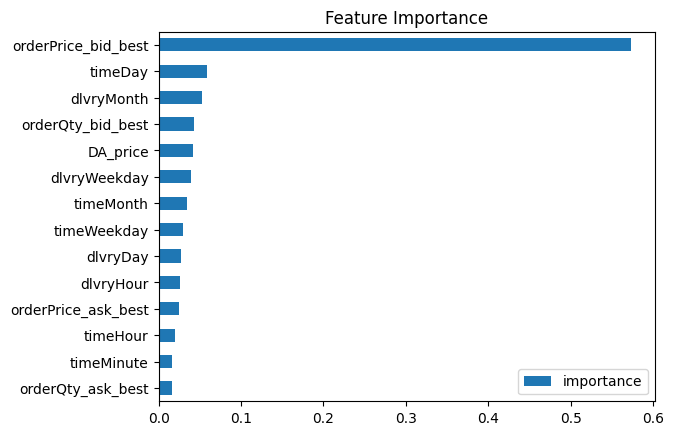

In [52]:
fi.sort_values(by='importance').plot(kind='barh', title='Feature Importance')
plt.show()